In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ones,vstack
from numpy.linalg import lstsq
from matplotlib import _cntr as cntr
import tensorflow as tf

from data import sample_gmm_2d, graph_data,graph_surface, labels_to_one_hot
from confusion_matrix import get_confusion_matrix
from confusion_matrix import eval_AP
from confusion_matrix import eval_perf_multi

In [22]:
import numpy as np
def fcann2_train(X,Y_, std = 1.0,learning_rate=0.5):
    input_size = 2
    hidden_size = 2
    output_size = 2
    n_iter = 10000
    
    W1 = std * np.random.randn(input_size, hidden_size)
    b1 = np.zeros(hidden_size)
    W2 = std * np.random.randn(hidden_size, output_size)
    b2 = np.zeros(output_size)
    
    Y_onehot = np.zeros((len(Y_),2))
    Y_onehot[range(len(Y_)),Y_] = 1
    
    for i in range(n_iter):
        layer_1, layer_2, probs = fcann2_forward(X,W1,b1,W2,b2)
        if i % 2000 == 0:
            val = -np.log(probs)*Y_onehot
            loss = np.sum(val)/len(Y_)
            print "Iteration = %d Loss = %f" %(i,loss)
        #grad softmax
        dscores = probs
        dscores[range(len(Y_)),Y_] -= 1
        dscores /= len(Y_)
        
        #grad last layer
        grad_W2 = np.dot(layer_1.T,dscores)
        grad_b2 = np.sum(dscores,axis=0)
        
        #grad trough relu
        grad_trough_relu = np.dot(dscores,W2.T)
        grad_trough_relu[layer_1<=0] = 0
        
        #grad first layer
        grad_W1 = np.dot(X.T,grad_trough_relu)
        grad_b1 = np.sum(grad_trough_relu,axis=0)
        
        
        W2+= -learning_rate*grad_W2
        b2+= -learning_rate*grad_b2
        W1+= -learning_rate*grad_W1
        b1+= -learning_rate*grad_b1
        
    return W2, b2, W1, b1
        
    
def fcann2_forward(X,W1,b1,W2,b2):
    # Compute the forward pass
    scores = None
    l1 = X.dot(W1) + b1
    l1 = np.dot(X, W1) + b1
    l1[l1<=0] = 0 # ReLu
    scores = l1.dot(W2) + b2
    scores_exp= np.exp(scores)
    sum_exp=np.sum(np.exp(scores),axis=1)
    probabilities = scores_exp/ sum_exp[:,None]
    return l1, scores, probabilities

def predict_c1_class(X,W1,b1,W2,b2):
    def classify(X):
        return fcann2_forward(X,W1,b1,W2,b2)[2][:,1]
    return classify


3836
Iteration = 0 Loss = 1.053182
Iteration = 2000 Loss = 0.017445
Iteration = 4000 Loss = 0.016869
Iteration = 6000 Loss = 0.016534
Iteration = 8000 Loss = 0.016256


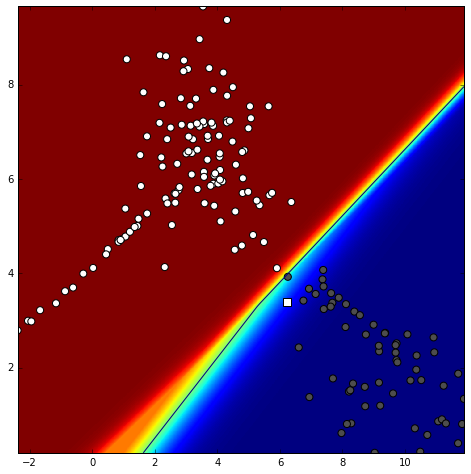

In [23]:
#np.random.seed(25321) isus... sve ista klasa za 4 2 30
# seed = 119 0.5 i 10000
#seed = 2519 eo nezz
# seed = 2215 0.01 learning rate 10000 iteracija
# 4700 1416 2612 3836
#from fcann2 import fcann2_train, predict_c1_class
seed = np.random.randint(0,5000)
print seed
np.random.seed(2612)
input_data, expected_output = sample_gmm_2d(6,2,30)

W2, b2, W1, b1 = fcann2_train(input_data, expected_output,learning_rate=0.1)
decfun = predict_c1_class(input_data,W1,b1,W2,b2)

# evaluate the model on the train set
probs = decfun(input_data)

# recover the predicted classes Y
my_predictions = probs >0.5
my_predictions = my_predictions.flatten()


# graph the decision surface
bbox=(np.min(input_data, axis=0), np.max(input_data, axis=0))

#axis limits of the graph
xmin, ymin = bbox[0]
xmax, ymax = bbox[1]
plt.figure(figsize=(8,8))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

graph_surface(decfun, bbox, offset=0.5)

# graph the data points
graph_data(input_data, expected_output, my_predictions)

# show the plot
plt.show()

Iteration = 0, loss = [array([ 0.66554117,  0.44795814,  0.01530208,  0.07125907,  0.00304511,
        0.94442624,  1.02934623,  0.5442791 ,  0.77872479,  1.90241396], dtype=float32)]
Iteration = 100, loss = [array([  2.76473247e-06,   7.50534749e-03,   5.17475270e-02,
         1.49494693e-01,   2.78762858e-02,   3.95082116e-01,
         1.93446681e-01,   4.68806876e-03,   2.41023395e-02,
         1.21211587e-02], dtype=float32)]
Iteration = 200, loss = [array([ 0.00721143,  0.02886458,  0.02079754,  0.09203529,  0.06261963,
        0.29732317,  0.12711978,  0.02303157,  0.05690435,  0.00071793], dtype=float32)]
Iteration = 300, loss = [array([  1.33178951e-02,   4.01516445e-02,   1.29346251e-02,
         7.44690374e-02,   7.88049251e-02,   2.65009165e-01,
         1.06312253e-01,   3.32130603e-02,   7.23767504e-02,
         1.36077742e-05], dtype=float32)]
Iteration = 400, loss = [array([  1.60176922e-02,   4.47477512e-02,   1.05211465e-02,
         6.85037971e-02,   8.51939544e-02,  

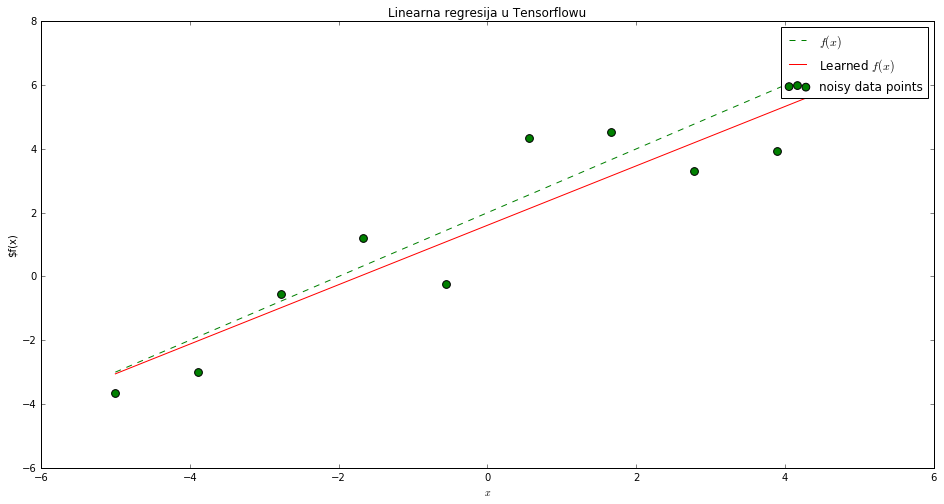

In [62]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def f(X):
    return X+2

def make_labels(X,std):
    return f(X) + np.random.normal(scale=std,size=len(X))

N=10
n_iter=1000
print_every = 100
input_data = np.linspace(-5,5,N)
output_data = make_labels(input_data,1)
analythic_grad = False
## 1. definicija računskog grafa
# podatci i parametri
X  = tf.placeholder(tf.float32, [None])
Y_ = tf.placeholder(tf.float32, [None])
a = tf.Variable(0.0)
b = tf.Variable(0.0)

polovina = tf.constant(0.5,tf.float32)

# afini regresijski model
Y = a * X + b

# kvadratni gubitak  * 0.5 da se derivacijom rijesi ova polovina i bude better
loss = polovina* (Y-Y_)**2 * (1./len(input_data))

# optimizacijski postupak: gradijentni spust learning rate ubije sveee aaaaa
trainer = tf.train.GradientDescentOptimizer(0.01)
train_op = trainer.minimize(loss)

## 2. inicijalizacija parametara
sess = tf.Session()
sess.run(tf.initialize_all_variables())
y_valid = Y
#gradient definišn
grads_and_vars = trainer.compute_gradients(loss, var_list=[a,b],)
apply_grads = trainer.apply_gradients(grads_and_vars)
## 3. učenje
# neka igre počnu!
for i in range(n_iter):
    
    #value = sess.run([grads_and_vars], feed_dict={X: [1], Y_: [3]})
    #print value
    #print "vrijednost izlaza", sess.run([Y], feed_dict={X: [1]})
    
    if i % print_every == 0:
        print "Iteration = %d, loss = %s" % (i, sess.run([loss],feed_dict={X: input_data, Y_: output_data}))
    #moj analiticki gradijent :D
    #print (sess.run([Y], feed_dict={X: [1]})[0] - 3)* 1
    if analythic_grad:
        sess.run(apply_grads,feed_dict={X: input_data, Y_: output_data})
        if i % print_every == 0:
            print "Iteration = %d, loss = %f" % (i,sess.run([loss],feed_dict={X: input_data, Y_: output_data}))
            print "Analythic gradient"
            print (sess.run([Y], feed_dict={X: [1]})[0] - 3)* 1
    else:
        val_loss, _, val_a,val_b = sess.run([loss, train_op, a,b], feed_dict={X: input_data, Y_: output_data})
    #print i
#     test tf.Printa
#     test = tf.constant([1.0,2.0])
#     test2 = tf.Print(test,[test],message=("test varijablica "))
#     sess.run([test2]) #printa u terminal :'( suzice
    
#     print i
#     print
#     val_loss, _, val_a,val_b = sess.run([loss, train_op, a,b], 
#         feed_dict={X: [1,2,3,4], Y_: [3,5,7,9]})
    #print(i,val_loss, val_a,val_b)
print
print sess.run([Y], feed_dict={X:input_data})
print sess.run([y_valid], feed_dict={X:input_data})
plt.figure(figsize=(16,8))
plt.plot(input_data,f(input_data),'--',c="green",label="$f(x)$")
plt.scatter(input_data,output_data,marker='o',s=60,c="green",label="noisy data points")
plt.plot(input_data,sess.run([Y], feed_dict={X:input_data})[0],c="red",label="Learned $f(x)$")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)")
plt.title("Linearna regresija u Tensorflowu")
plt.show()
sess.close()

In [65]:
import tensorflow as tf
class TFLogreg:
    def __init__(self,D, C, param_delta=0.01,param_lambda=1e-4, std = 1.0):
        """Arguments:
           - D: dimensions of each datapoint
           - param_delta: training step
        """
        self.sess = tf.Session()
        
        # definicija podataka i parametara:
        # definirati self.X, self.Yoh_, self.W, self.b
        # ...
        self.X = tf.placeholder(tf.float32, [None,D])
        self.Yoh_ = tf.placeholder(tf.float32, [None,C])
        self.W = tf.Variable(tf.random_normal([D,C],stddev=std))
        self.b1 = tf.Variable(tf.random_normal([C],stddev=std))

        # formulacija modela: izračunati self.probs
        #   koristiti: tf.matmul, tf.nn.softmax
        # ...
        self.model_score = tf.matmul(self.X,self.W) + self.b1
        self.model_softmax = tf.nn.softmax(self.model_score) #vektor C
        self.Y = self.model_softmax

        # formulacija gubitka: self.loss
        #   koristiti: tf.log, tf.reduce_sum, tf.reduce_mean
        # ...
        #Y - izlaz
        #Yoh - onehot 
        self.loss = (tf.reduce_mean(-tf.reduce_sum(tf.log(self.Y)*self.Yoh_,reduction_indices=1)
                    + param_lambda*tf.nn.l2_loss(self.W)))

        # formulacija operacije učenja: self.train_step
        #   koristiti: tf.train.GradientDescentOptimizer,
        #              tf.train.GradientDescentOptimizer.minimize
        # ...
        self.trainer = tf.train.GradientDescentOptimizer(param_delta)
        self.optimizer = self.trainer.minimize(self.loss)
        # instanciranje izvedbenog konteksta: self.session
        #   koristiti: tf.Session
        # ...
        
        pass

    def train(self, X, Yoh_, param_niter):
        """Arguments:
           - X: actual datapoints [NxD]
           - Yoh_: one-hot encoded labels [NxC]
           - param_niter: number of iterations
        """
        # incijalizacija parametara
        #   koristiti: tf.initialize_all_variables
        # ...
        self.sess.run(tf.initialize_all_variables())
        for i in range(param_niter):
            _, loss = self.sess.run([self.optimizer, self.loss], feed_dict={self.X: X, self.Yoh_: Yoh_})
        # optimizacijska petlja
        #   koristiti: tf.Session.run
        # ...
        pass
        
    def eval(self, X):
        """Arguments:
           - X: actual datapoints [NxD]
           Returns: predicted class probabilites [NxC]
        """
        #   koristiti: tf.Session.run
        return self.sess.run(self.Y,feed_dict={self.X:X})
        pass
    
    def __del__(self):
        self.sess.close()

In [2]:
import tensorflow as tf
class TFDeep:
    def __init__(self, layer, param_delta=0.01, param_lambda=1e-4, activation=tf.nn.relu, 
                 std =1.0, optimizer = tf.train.GradientDescentOptimizer,checkpoint_file = "model"):
        """Arguments:
           - D: dimensions of each datapoint 
           - C: number of classes
           - param_delta: training step
        """
        self.reset()
        self.checkpoint_file = checkpoint_file
        self.sess = tf.Session()
        
        # definicija podataka i parametara:
        # definirati self.X, self.Yoh_, self.W, self.b
        # ...
        self.X = tf.placeholder(tf.float32, [None,layer[0]],name="input")
        self.Yoh_ = tf.placeholder(tf.float32, [None,layer[-1]],name="output")
        prev = layer[0]
        out = self.X
        
        #Makni kad prebacis u pycharm
        l2_reg= None
        for dim in layer[1:-1]:
            temp_W = tf.Variable(tf.random_normal([prev,dim],stddev=std))
            temp_b = tf.Variable(tf.random_normal([dim],stddev=std))
            out = activation(tf.matmul(out,temp_W)+temp_b)
            prev = dim
            if l2_reg == None:
                l2_reg = tf.nn.l2_loss(temp_W) + tf.nn.l2_loss(temp_b)
            else:
                l2_reg += tf.nn.l2_loss(temp_W) + tf.nn.l2_loss(temp_b)
            
            
        temp_W = tf.Variable(tf.random_normal([prev,layer[-1]],stddev=std),name="last_layer_w")
        temp_b = tf.Variable(tf.random_normal([layer[-1]],stddev=std),name="last_layer_b")
        
        self.last_layer_w = temp_W
        
        out = tf.nn.softmax(tf.matmul(out,temp_W)+temp_b)
        if l2_reg != None:
            l2_reg += tf.nn.l2_loss(temp_W) + tf.nn.l2_loss(temp_b)
        else:
            l2_reg = tf.nn.l2_loss(temp_W) + tf.nn.l2_loss(temp_b)
            
        self.Y = out

        # formulacija gubitka: self.loss
        #   koristiti: tf.log, tf.reduce_sum, tf.reduce_mean
        # ...
        #Y - izlaz
        #Yoh - onehot 
        self.loss = (tf.reduce_mean(-tf.reduce_sum(tf.log(self.Y)*self.Yoh_,reduction_indices=1)
                        + param_lambda*l2_reg))

        # formulacija operacije učenja: self.train_step
        #   koristiti: tf.train.GradientDescentOptimizer,
        #              tf.train.GradientDescentOptimizer.minimize
        # ...
        self.trainer = optimizer(param_delta)
        self.optimizer = self.trainer.minimize(self.loss)
        # instanciranje izvedbenog konteksta: self.session
        #   koristiti: tf.Session
        # ...
        
        pass

    def train(self, X, Yoh_, param_niter, print_every=1000):
        """Arguments:
           - X: actual datapoints [NxD]
           - Yoh_: one-hot encoded labels [NxC]
           - param_niter: number of iterations
        """
        # incijalizacija parametara
        #   koristiti: tf.initialize_all_variables
        # ...
        self.sess.run(tf.initialize_all_variables())
        for i in range(param_niter):
            _, loss = self.sess.run([self.optimizer, self.loss], feed_dict={self.X: X, self.Yoh_: Yoh_})
            if i%print_every==0:
                print "Iteration = %d, Loss = %f" % (i, loss)
        # optimizacijska petlja
        #   koristiti: tf.Session.run
        # ...
        pass
        
    def eval(self, X):
        """Arguments:
           - X: actual datapoints [NxD]
           Returns: predicted class probabilites [NxC]
        """
        #   koristiti: tf.Session.run
        return self.sess.run(self.Y,feed_dict={self.X:X})
        pass
    
    def get_last_layer_weights(self):
        return self.sess.run([self.last_layer_w])
    
    def save(self,checkpoint_file="test.chk"):
        self.saver = tf.train.Saver()
        self.saver.save(self.sess, self.checkpoint_file)

    def restore(self,checkpoint_file="test.chk"):
        self.saver = tf.train.Saver()
        self.saver.restore(self.sess, self.checkpoint_file)

    def reset(self):
        tf.reset_default_graph()
        
    def __del__(self):
        self.sess.close()

In [66]:
from sklearn import svm
class KSVMWrap:
    def __init__(self, X, Y_, c=1, g='auto'):
        """Arguments:
            X,Y_: podatci i točni indeksi razreda
            c:    relativni značaj podatkovne cijene
            g:    širina RBF jezgre
        """
        self.clf = svm.SVC(C=c,gamma=g,probability=True)
        self.clf.fit(X, Y_)

    def predict(self, X):
        return self.clf.fit(X, Y_)
        
    def scores(self, X):
        #np.where(clf.classes_ == zeljena klasa)
        return self.clf.classes_, self.clf.predict_proba(X) 
    
    def support(self):
        return self.clf.support_

Iteration = 0, Loss = 0.674173
Iteration = 2500, Loss = 0.499744
Iteration = 5000, Loss = 0.289759
Iteration = 7500, Loss = 0.252084
Iteration = 10000, Loss = 0.249336
Iteration = 12500, Loss = 0.248267
Iteration = 15000, Loss = 0.246961
Iteration = 17500, Loss = 0.246071
Iteration = 20000, Loss = 0.245367
Iteration = 22500, Loss = 0.244786
Iteration = 25000, Loss = 0.244296
Iteration = 27500, Loss = 0.243797
            0     1
     0[    56     4]
     1[     6   114]
accuracy
0.944444444444
precision
[0.90322580645161288, 0.96610169491525422]
recall
[0.93333333333333335, 0.94999999999999996]
AP_c0
0.973587783399
AP_c1
0.993158410423


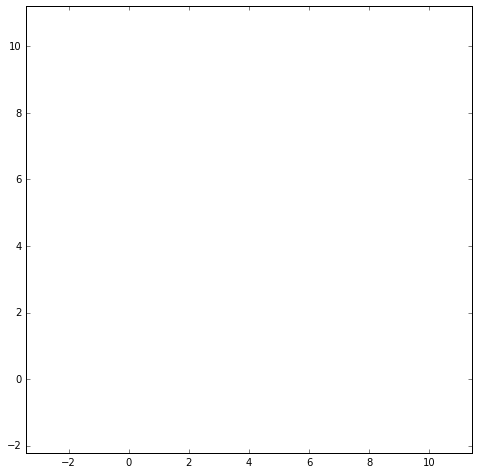

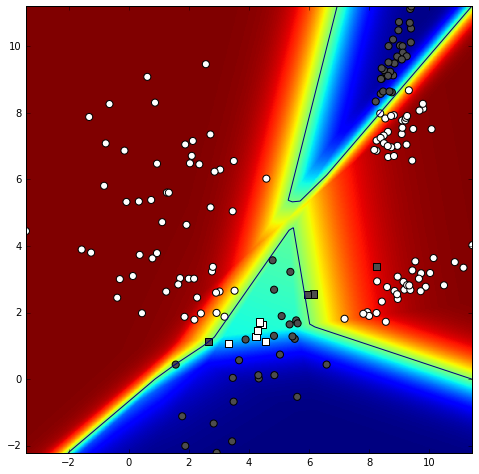

In [7]:
def predict_c1_class_tf(X):
    def classify(X):
        return tfLog.eval(X)[:,1]
    return classify
C=2
#seed = np.random.randint(0,500000)
#print seed
np.random.seed(423245)
#306285
#423245
layers = [2,10,10,2]
input_data, expected_output = sample_gmm_2d(6,C,30)

# tfLog = TFLogreg(2,C)
tfLog = TFDeep(layers,param_delta=0.01,param_lambda=0.01,activation=tf.nn.relu,std=0.1)
tfLog.train(input_data,labels_to_one_hot(expected_output,C),30000,print_every=2500)
decfun = predict_c1_class_tf(input_data)

# evaluate the model on the train set
probs = tfLog.eval(input_data)

# recover the predicted classes Y
my_predictions = probs[:,1] >0.5
my_predictions = my_predictions.flatten()


# graph the decision surface
bbox=(np.min(input_data, axis=0), np.max(input_data, axis=0))

#axis limits of the graph
xmin, ymin = bbox[0]
xmax, ymax = bbox[1]
plt.figure(figsize=(8,8))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

possible_labels = np.array(range(C))
mat = get_confusion_matrix(my_predictions,expected_output,possible_labels,True)
accuracy, prec, rec = eval_perf_multi(mat)
AP_c0 = eval_AP(expected_output[probs[:,0].argsort()],0)
AP_c1 = eval_AP(expected_output[probs[:,1].argsort()],1)

print "accuracy"
print accuracy
print "precision"
print prec
print "recall"
print rec
print "AP_c0"
print AP_c0
print "AP_c1"
print AP_c1

graph_surface(decfun, bbox, offset=0.5)

# graph the data points
graph_data(input_data, expected_output, my_predictions)

# show the plot
plt.show()

In [16]:
# tfLog.save()
# tfLog.reset()
# tfLog = TFDeep(layers,param_delta=0.01,param_lambda=0.01,activation=tf.nn.relu,std=0.1)
# tfLog.restore()
# tfLog.get_last_layer_weights()

[array([[ -1.06285870e+00,   1.06649983e+00],
        [  1.96727440e-02,  -2.62921937e-02],
        [ -3.70682210e-01,   3.71162802e-01],
        [ -1.09401011e+00,   1.10192716e+00],
        [ -3.42822880e-01,   3.39695305e-01],
        [  8.52440774e-01,  -8.51315022e-01],
        [ -7.57789891e-03,   2.70205892e-05],
        [  1.81935832e-03,  -2.97697959e-03],
        [  1.40267727e-03,   2.88089132e-03],
        [ -4.20167059e-01,   4.12221491e-01]], dtype=float32)]

            0     1
     0[    57     3]
     1[     1   119]
accuracy
0.977777777778
precision
[0.98275862068965514, 0.97540983606557374]
recall
[0.94999999999999996, 0.9916666666666667]
AP_c0
0.995968448068
AP_c1
0.998880493509


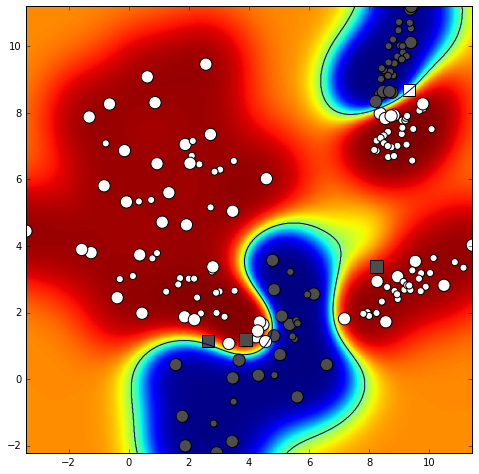

In [70]:
def predict_c1_class_tf(X):
    def classify(X):
        return tfLog.eval(X)[:,1]
    return classify

def predict_c1_class_tf(X):
    def classify(X):
        return tfLog.scores(X)[1][:,1]
    return classify

C=2
#seed = np.random.randint(0,500000)
#print seed
np.random.seed(423245)
#306285
#423245
input_data, expected_output = sample_gmm_2d(6,C,30)

tfLog = KSVMWrap(input_data,expected_output)
decfun = predict_c1_class_tf(input_data)

# evaluate the model on the train set
probs = tfLog.scores(input_data)[1]

# recover the predicted classes Y
my_predictions = probs[:,1] >0.5
my_predictions = my_predictions.flatten()


# graph the decision surface
bbox=(np.min(input_data, axis=0), np.max(input_data, axis=0))

#axis limits of the graph
xmin, ymin = bbox[0]
xmax, ymax = bbox[1]
plt.figure(figsize=(8,8))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

possible_labels = np.array(range(C))
mat = get_confusion_matrix(my_predictions,expected_output,possible_labels,True)
accuracy, prec, rec = eval_perf_multi(mat)
AP_c0 = eval_AP(expected_output[probs[:,0].argsort()],0)
AP_c1 = eval_AP(expected_output[probs[:,1].argsort()],1)

print "accuracy"
print accuracy
print "precision"
print prec
print "recall"
print rec
print "AP_c0"
print AP_c0
print "AP_c1"
print AP_c1

graph_surface(decfun, bbox, offset=0.5)

# graph the data points
graph_data(input_data, expected_output, my_predictions,special=tfLog.support())

# show the plot
plt.show()

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

def predict_c1_class_tf(X):
    def classify(X):
        return tfLog.eval(X)[:,1]
    return classify
with tf.device("/gpu:0"):
    C=2
    layers = [784,10]

    tfLog = TFDeep(layers,param_delta=0.01,param_lambda=0.01,std=0.001,checkpoint_file="model-[784,10].ckpt")
    tfLog.train(mnist.train.images,mnist.train.labels,10000,print_every=100)
    tfLog.save()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration = 0, Loss = 2.303171
Iteration = 100, Loss = 1.562556
Iteration = 200, Loss = 1.212430
Iteration = 300, Loss = 1.027789
Iteration = 400, Loss = 0.917420
Iteration = 500, Loss = 0.844905
Iteration = 600, Loss = 0.793937
Iteration = 700, Loss = 0.756317
Iteration = 800, Loss = 0.727511
Iteration = 900, Loss = 0.704820
Iteration = 1000, Loss = 0.686538
Iteration = 1100, Loss = 0.671537
Iteration = 1200, Loss = 0.659041
Iteration = 1300, Loss = 0.648498
Iteration = 1400, Loss = 0.639505
Iteration = 1500, Loss = 0.631762
Iteration = 1600, Loss = 0.625041
Iteration = 1700, Loss = 0.619164
Iteration = 1800, Loss = 0.613992
Iteration = 1900, Loss = 0.609415
Iteration = 2000, Loss = 0.605342
Iteration = 2100, Loss = 0.601702
Iteration = 2200, Loss = 0.598435
Iteration = 2300, Loss = 0.595491
It

In [ ]:
probs = tfLog.eval(mnist.train.images)
# recover the predicted classes Y
my_predictions = probs[:,1] >0.5
my_predictions = my_predictions.flatten()


# graph the decision surface
bbox=(np.min(input_data, axis=0), np.max(input_data, axis=0))

#axis limits of the graph
possible_labels = np.array(range(C))
mat = get_confusion_matrix(np.argmax(mnist.train.labels,axis=1),np.argmax(mnist.train.labels,axis=1),np.unique(np.argmax(probs,axis=1)),True,format_length=10)
accuracy, prec, rec = eval_perf_multi(mat)
AP_c0 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,0].argsort()],0)
AP_c1 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,1].argsort()],1)
AP_c2 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,2].argsort()],2)
AP_c3 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,3].argsort()],3)
AP_c4 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,4].argsort()],4)
AP_c5 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,5].argsort()],5)
AP_c6 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,6].argsort()],6)
AP_c7 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,7].argsort()],7)
AP_c8 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,8].argsort()],8)
AP_c9 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,9].argsort()],9)

print "accuracy"
print accuracy
print "precision"
print prec
print "recall"
print rec
print "AP 0-%d,1-%d,2-%d,3-%d,4-%d,5-%d,6-%d,7-%d,8-%d,9-%d" %(AP_c0,AP_c1,AP_c2,AP_c3,AP_c4,AP_c5,AP_c6,AP_c7,AP_c8,AP_c9)